In [1]:
import sys
import os

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np

sys.path.append(os.getcwd())
from load_data import *
from plotting_tools import *

sys.path.append('../3_score/')
from optimize import Scores
from fingerprint import FuzzyFingerPrint

In [23]:
## useful class specifications:
# Ligand -- attributes: crystal (currently not used/none), poses (dict of pose_num:pose).
# Pose -- attributes: rmsd (float), fp (Fingerprint, num (integer), gscore (float)
# FuzzyFingerPrint -- attributes: pdb, feats (dict of residue name:interaction list).

# crystals: maps structures to Poses, 
#           e.g., crystals['4LDO'] = Pose(rmsd=0, fingerprint, num=0, gscore=0)
# glides:   maps ligand_struct, grid_struct to Ligands, 
#           e.g., glides['4LDO']['4LDO'] = Ligand(...)

## STEP 1:
## load in the crystal structures, docking results, and fingerprints

receptor = 'TRMD'
(xcrystals, xglides, ligs, structs) = load_data(receptor,w=[10,10,10,1,0],require_fp=True)

Loading crystal structures...
Loading glidescores...
0 of 1225 total pairs failed to dock.
Loading fingerprints...
Loading docking results...


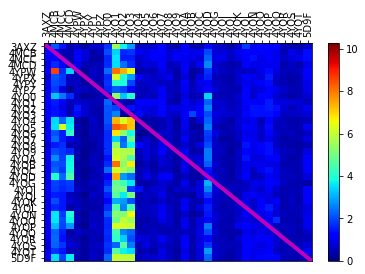

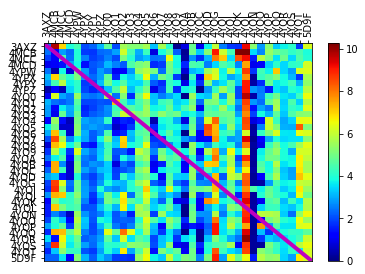

got lucky on 48 of 1225 pairs.


In [24]:
## STEP 2:
## visualize docking results

# in the heatmaps, each row is a structure and each column is a ligand

n = 25

get_ipython().magic(u'matplotlib inline')

best_rmsd_matrix = get_docking_stats(ligs, structs, xglides, n, lambda x: np.min(x) if x != [] else np.nan)
heatmap(best_rmsd_matrix, ligs, structs)

var_mat = get_docking_stats(ligs, structs, xglides, n, lambda x: np.var(x) if x != [] else np.nan)
heatmap(var_mat, ligs, structs)

helpfully_frozen(ligs, structs, xglides, n)

In [ ]:
get_ipython().magic(u'matplotlib inline')

# [ligands], struct, glides, num_poses, glidscore=True (if false, plot vs pose_number instead)
#plot_docking_output(['4FT9'],'4FTA',xglides,25,True)

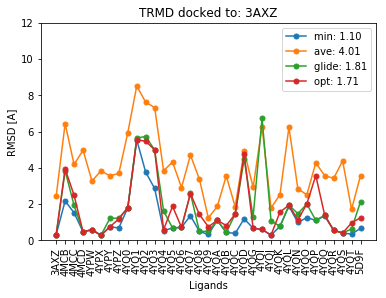

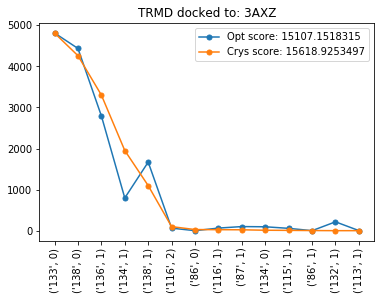

3AXZ performance:
| min | ave | glide | opt |
| 1.10 | 4.01 | 1.81 | 1.71 |


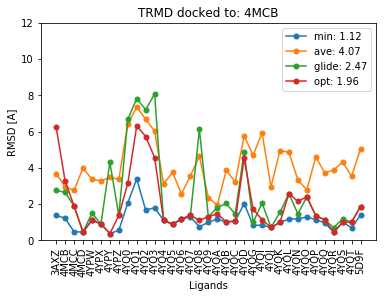

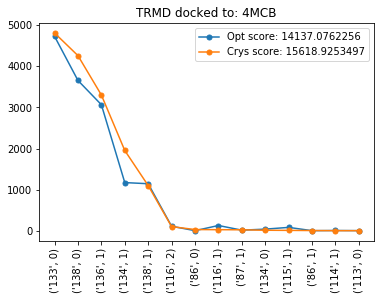

4MCB performance:
| min | ave | glide | opt |
| 1.12 | 4.07 | 2.47 | 1.96 |


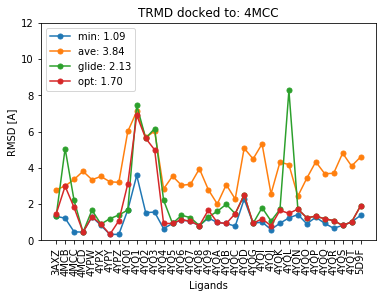

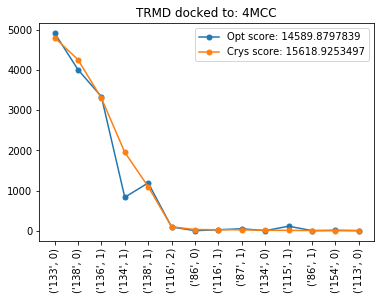

4MCC performance:
| min | ave | glide | opt |
| 1.09 | 3.84 | 2.13 | 1.70 |


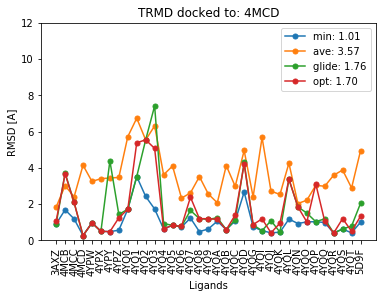

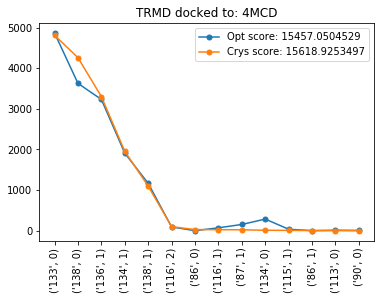

4MCD performance:
| min | ave | glide | opt |
| 1.01 | 3.57 | 1.76 | 1.70 |


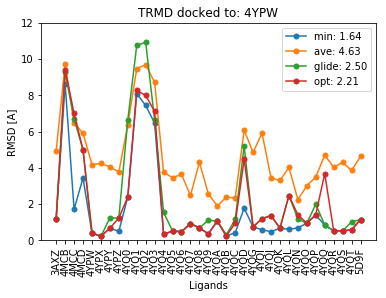

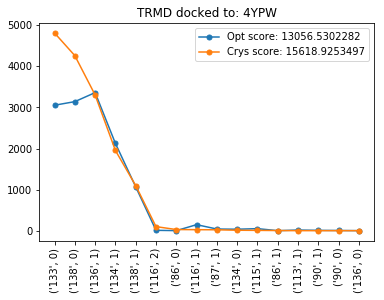

4YPW performance:
| min | ave | glide | opt |
| 1.64 | 4.63 | 2.50 | 2.21 |


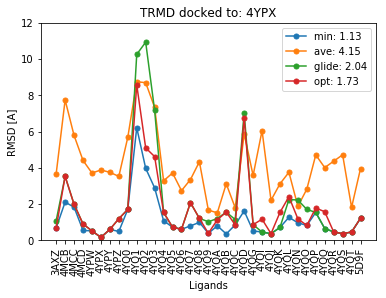

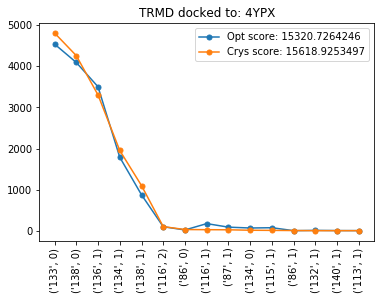

4YPX performance:
| min | ave | glide | opt |
| 1.13 | 4.15 | 2.04 | 1.73 |


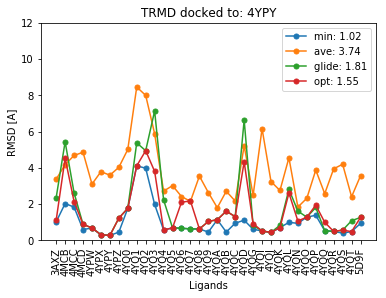

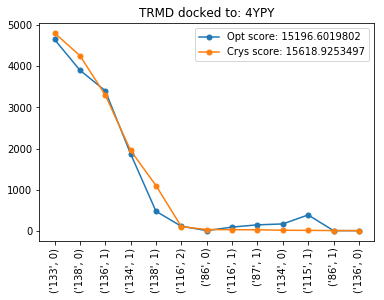

4YPY performance:
| min | ave | glide | opt |
| 1.02 | 3.74 | 1.81 | 1.55 |


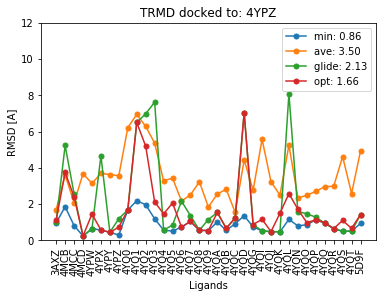

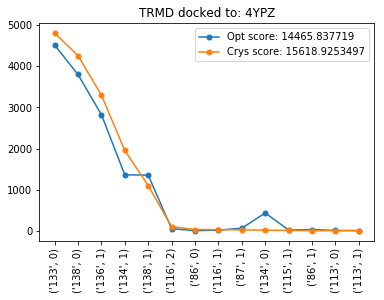

4YPZ performance:
| min | ave | glide | opt |
| 0.86 | 3.50 | 2.13 | 1.66 |


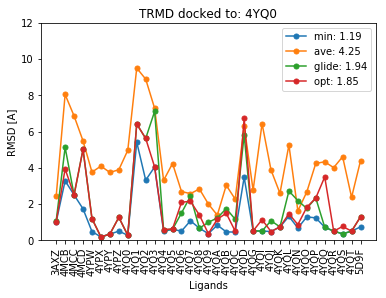

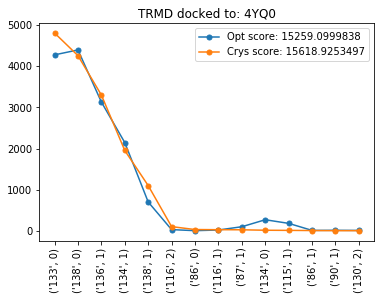

4YQ0 performance:
| min | ave | glide | opt |
| 1.19 | 4.25 | 1.94 | 1.85 |


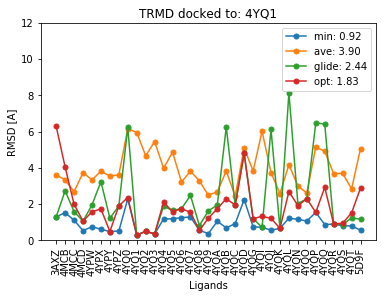

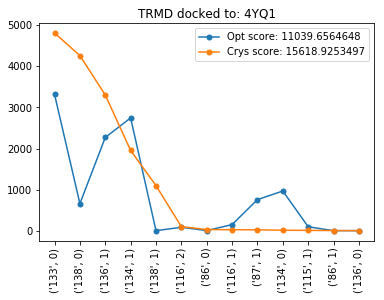

4YQ1 performance:
| min | ave | glide | opt |
| 0.92 | 3.90 | 2.44 | 1.83 |


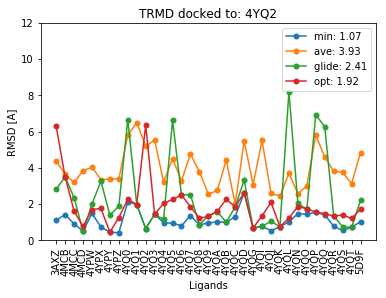

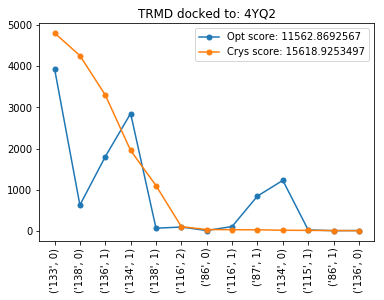

4YQ2 performance:
| min | ave | glide | opt |
| 1.07 | 3.93 | 2.41 | 1.92 |


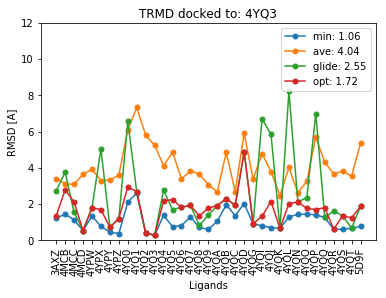

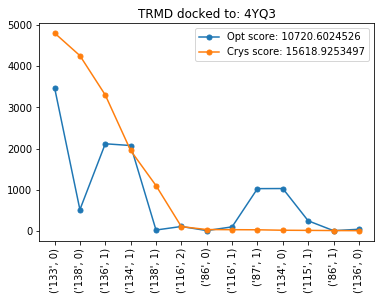

4YQ3 performance:
| min | ave | glide | opt |
| 1.06 | 4.04 | 2.55 | 1.72 |


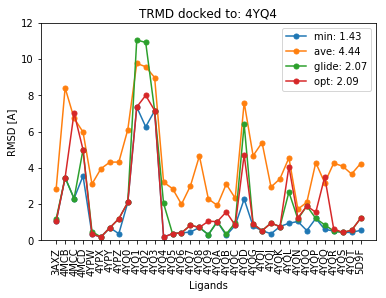

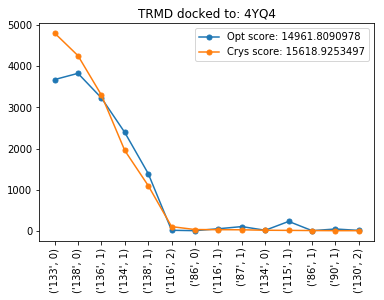

4YQ4 performance:
| min | ave | glide | opt |
| 1.43 | 4.44 | 2.07 | 2.09 |


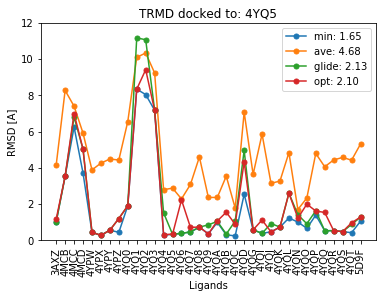

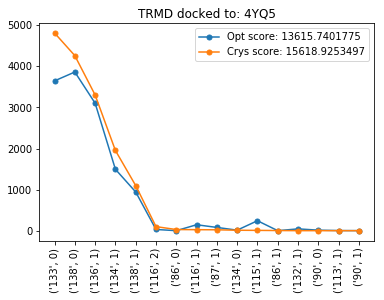

4YQ5 performance:
| min | ave | glide | opt |
| 1.65 | 4.68 | 2.13 | 2.10 |


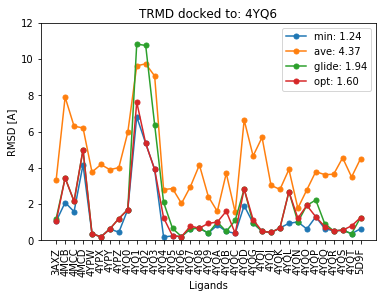

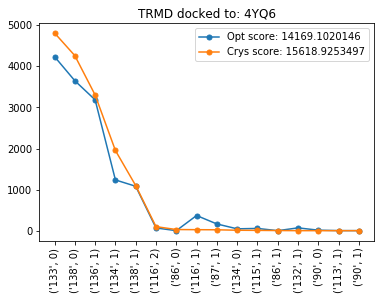

4YQ6 performance:
| min | ave | glide | opt |
| 1.24 | 4.37 | 1.94 | 1.60 |


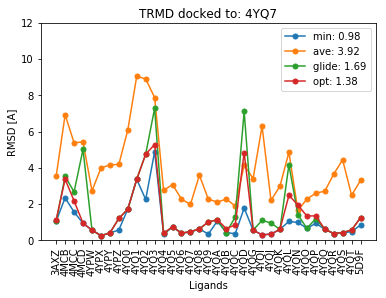

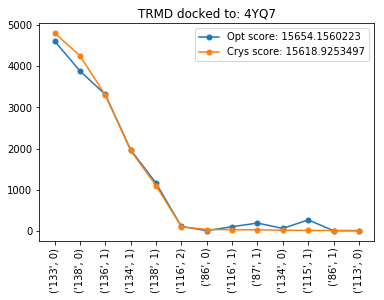

4YQ7 performance:
| min | ave | glide | opt |
| 0.98 | 3.92 | 1.69 | 1.38 |


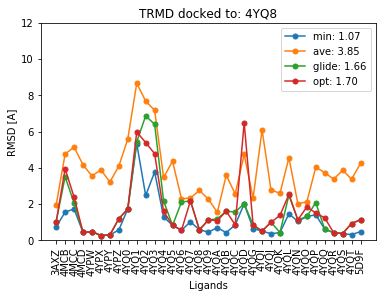

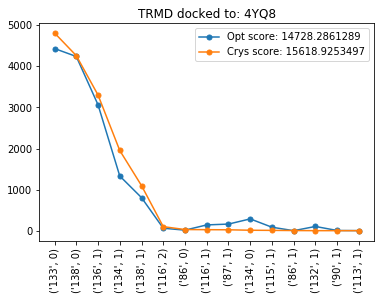

4YQ8 performance:
| min | ave | glide | opt |
| 1.07 | 3.85 | 1.66 | 1.70 |


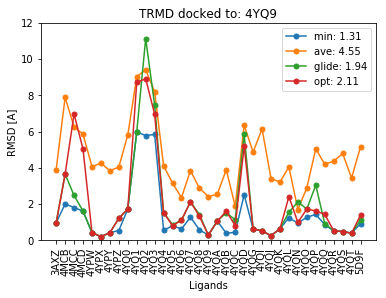

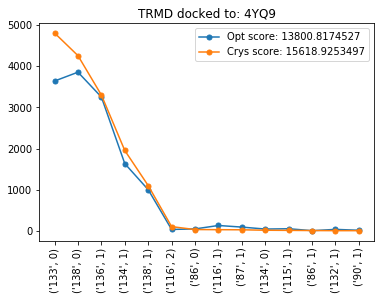

4YQ9 performance:
| min | ave | glide | opt |
| 1.31 | 4.55 | 1.94 | 2.11 |


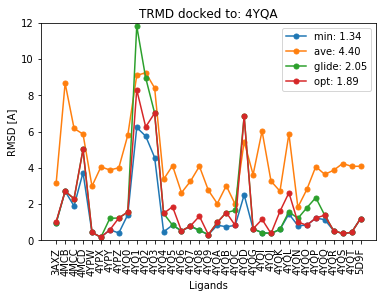

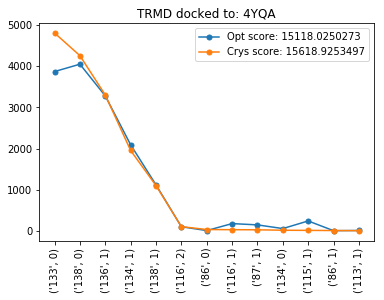

4YQA performance:
| min | ave | glide | opt |
| 1.34 | 4.40 | 2.05 | 1.89 |


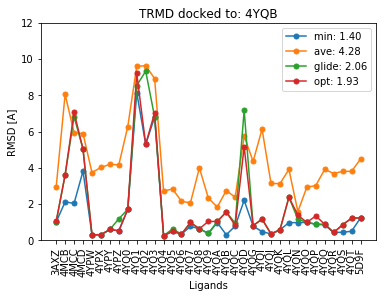

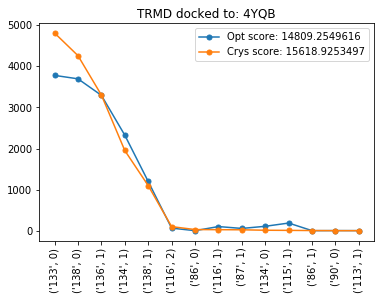

4YQB performance:
| min | ave | glide | opt |
| 1.40 | 4.28 | 2.06 | 1.93 |


In [ ]:
## STEP 4:
## score all pairs of ligands
#print glides.keys()
#best_rmsd_matrix = best_pose(glides.keys(), glides.keys(), glides, 50)
#best_rmsd_matrix2 = best_pose(xglides.keys(), xglides.keys(), xglides, 25)

get_ipython().magic(u'matplotlib inline')

all_final = {}

for struct in structs:
    filt_lig = [l for l in ligs]# if best_rmsd_matrix[structs.index(struct)][ligs.index(l)] < 1.5]
        
    scores = Scores(xglides, xcrystals, filt_lig, struct, n)
    title = '{} docked to: {}'.format(receptor, struct)
    final_rmsds = plot_final_rmsds(scores, title)
    
    crystal_cluster = {(l, -1):xcrystals[l].fp for l in filt_lig}
    opt_cluster = [(l,p) for (l,p) in scores.optimized_scores.items()]
    opt_cluster = {(l,p):xglides[l][struct].poses[p].fp for (l,p) in opt_cluster}
    plot_shared_interactions(crystal_cluster, c2=opt_cluster, max_r=20,
                             lab1='Crys', lab2='Opt', title=title,interactions=[0,1,2])
    
    #print opt_cluster.keys()
    
    a = scores.all_analysis
    print struct, 'performance:'
    print_table({i:a[i][1][:] for i in a})
    for i in a:
        if i not in all_final: all_final[i] = []
        all_final[i].extend(a[i][1][:])

print 'average across all data:'
print_table(all_final)